# K-means Clustering and Principal Component Analysis

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.io as sio
%matplotlib inline

## 1 K-means clustering

In [2]:
df = sio.loadmat('ex7data2.mat')
X = df['X']

### 1.1 Find closest centroids

In [3]:
K = 3
initial_centroids = np.array([[3, 3], [6, 2], [8, 5]])

Set $c^{(i)} := j$ that minimizes $||x^{i} - \mu_{j}||^{2}$

In [4]:
def findClosestCentroids(X, centroids):
    K = centroids.shape[0]
    idx = np.zeros(X.shape[0]).astype(int)
    
    for i in range(X.shape[0]):
        dmin = 1e6
        for j in range(K):
            d = np.sqrt(np.sum((X[i,:] - centroids[j,:])**2))
            if d < dmin:
                idx[i] = j
                dmin = d
    return idx

In [5]:
# Should be 0, 2, 1 for first 3 examples
idx = findClosestCentroids(X, initial_centroids)
idx[0:3]

array([0, 2, 1])

### 1.2 Compute centroid means

$\mu_{k} := \frac{1}{|C_{k}|} \sum_{i \in C_{k}}x^{(i)}$

In [6]:
def computeCentroids(X, idx, K):
    m, n = X.shape
    centroids = np.zeros((K, n))
    for i in range(m):
        centroids[idx[i],:] += X[i,:]
    for i in range(K):
        centroids[i,:] /= np.sum(idx == i)
    return centroids

In [7]:
# Should be:
# 2.428301, 3.157924
# 5.813503, 2.633656
# 7.119387, 3.616684
computeCentroids(X, idx, K)

array([[2.42830111, 3.15792418],
       [5.81350331, 2.63365645],
       [7.11938687, 3.6166844 ]])

In [8]:
df = sio.loadmat('ex7data2.mat')
X = df['X']
K = 3
initial_centroids = np.array([[3., 3.], [6., 2.], [8., 5.]])
max_iters = 10

In [9]:
def runKmeans(X, initial_centroids, max_iters, plot_progress=False, rand_init=False):
    m, n = X.shape
    K = initial_centroids.shape[0]
    if rand_init:
        X = np.random.permutation(X)
        initial_centroids = X[:K]
    centroids = initial_centroids
    previous_centroids = centroids
    for i in range(max_iters):
        idx = findClosestCentroids(X, centroids)
        centroids = computeCentroids(X, idx, K)
        if plot_progress:
            for j in range(K):
                plt.scatter(X[idx==j,0], X[idx==j,1], marker='.')
            plt.plot(centroids[:,0], centroids[:,1], marker='x', 
                        markersize=10, lw=0, color='black', mew=3)
            plt.show()
    return centroids, idx

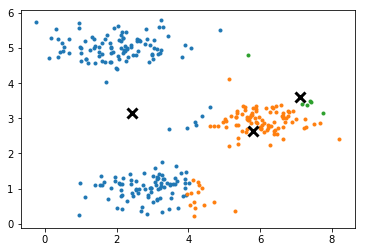

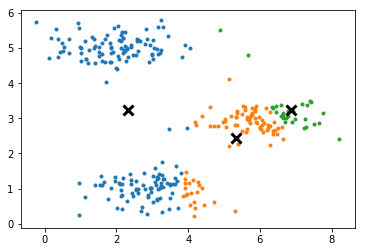

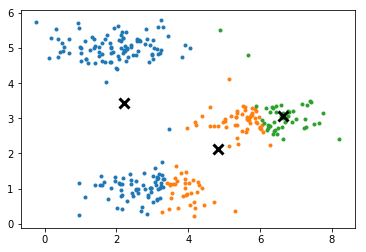

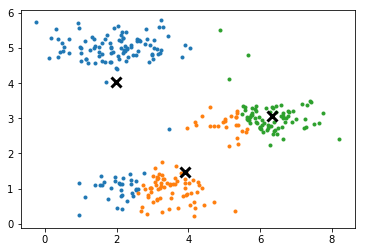

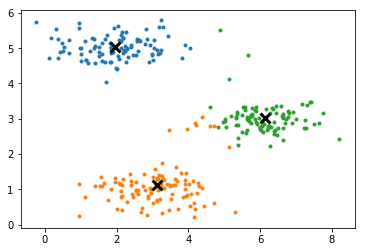

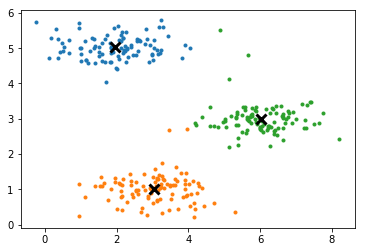

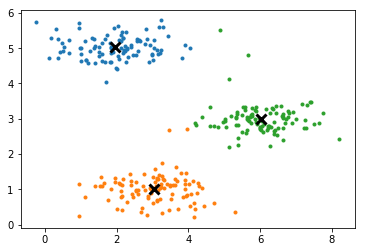

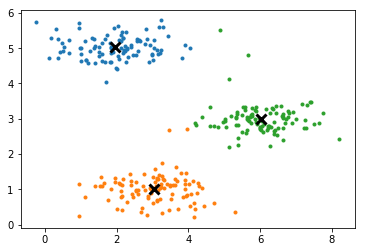

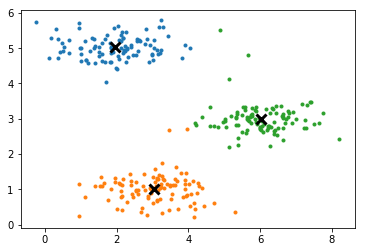

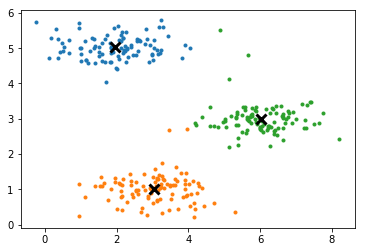

In [10]:
centroids, idx = runKmeans(X, initial_centroids, max_iters, True)

### 1.3 Random initialization

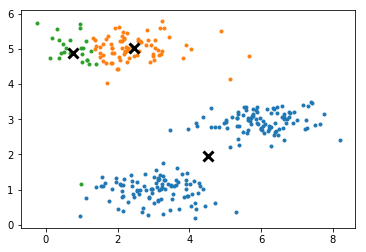

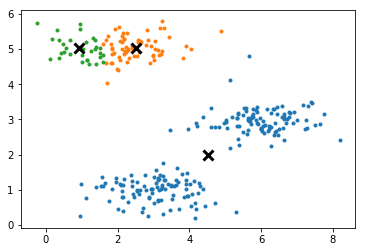

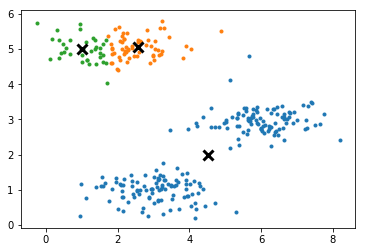

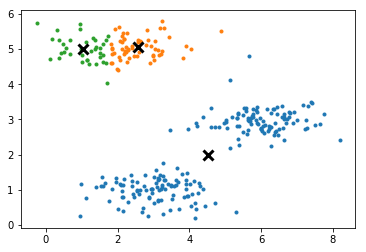

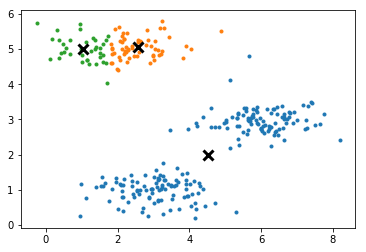

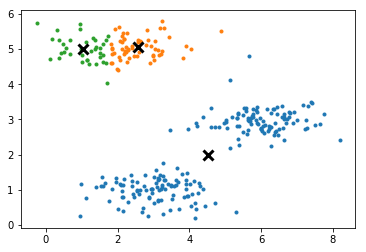

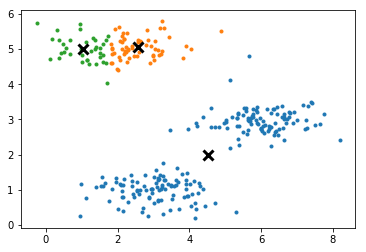

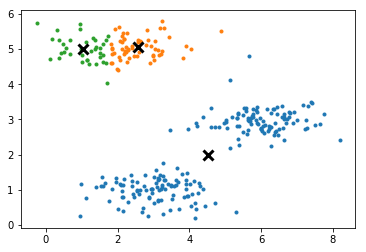

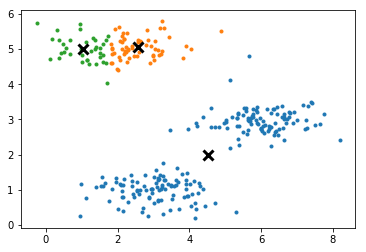

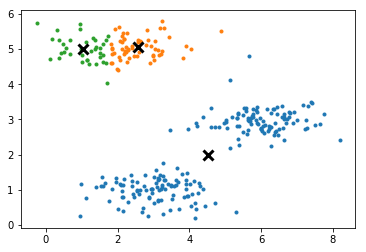

In [11]:
# Run multiple times. It can get stuck in a non-optimal clustering
centroids, idx = runKmeans(X, initial_centroids, max_iters, True, True)

## 1.4 Image compression with K-means

In [12]:
A = plt.imread('bird_small.png')

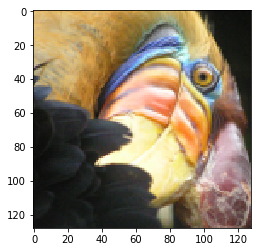

In [13]:
plt.imshow(A)

In [14]:
A = A / 255
X = A.reshape(A.shape[0]*A.shape[1], 3)

In [15]:
X.shape

(16384, 3)

In [16]:
K = 16
max_iters = 10

In [17]:
# Too slow; see sklearn implementation below
#centroids, idx = runKmeans(X, np.zeros((X.shape)), max_iters, False, True)

In [18]:
#X_recovered = centroids[idx,:]
#X_recovered.reshape(A.shape[0], A.shape[1], 3)*255

In [19]:
#A = plt.imread('bird_small.png')
#plt.imshow(A)
#plt.title('Original')
#plt.show()

In [20]:
#plt.imshow(X_recovered)
#plt.title('Compressed')
#plt.show()

## 1.4 Scikit learn

In [21]:
from sklearn.cluster import KMeans

In [22]:
df = sio.loadmat('ex7data2.mat')
X = df['X']
K = 3

In [23]:
kmeans = KMeans(n_clusters=K).fit(X)

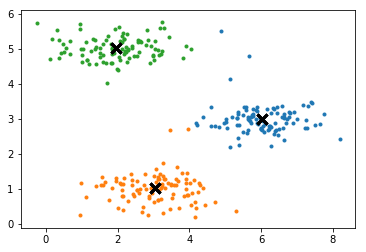

In [24]:
for j in range(K):
    plt.scatter(X[kmeans.labels_==j,0], X[kmeans.labels_==j,1], marker='.')
    plt.plot(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], marker='x', 
             markersize=10, lw=0, color='black', mew=3)
plt.show()

In [25]:
kmeans.cluster_centers_

array([[6.03366736, 3.00052511],
       [3.04367119, 1.01541041],
       [1.95399466, 5.02557006]])

### 1.4.1 Image compression with scikit learn

In [26]:
A = plt.imread('bird_small.png')
A = A / 255
X = A.reshape(A.shape[0]*A.shape[1], 3)
K = 16

In [27]:
kmeans = KMeans(n_clusters=K).fit(X)

In [28]:
X_recovered = kmeans.cluster_centers_[kmeans.labels_,:]
X_recovered = X_recovered.reshape(A.shape[0], A.shape[1], 3)*255

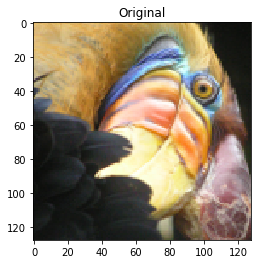

In [29]:
# Around 33K in storage
A = plt.imread('bird_small.png')
plt.imshow(A)
plt.title('Original')
plt.show()

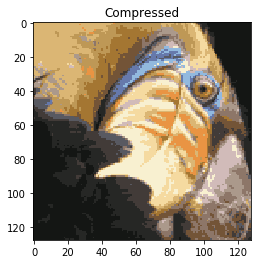

In [30]:
# Around 11K in storage
plt.imshow(X_recovered)
plt.title('Compressed')
#plt.imsave('bird_small_compress.png', X_recovered)
plt.show()

## 2 Principal component analysis
### 2.1 Implementing PCA

In [31]:
df = sio.loadmat('ex7data1.mat')
X = df['X']

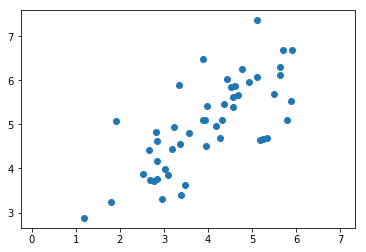

In [32]:
plt.xlim([0.5, 6.5])
plt.ylim([2.0, 8.0])
plt.axis('equal')
plt.plot(X[:,0], X[:,1], lw=0, marker='o')
plt.show()

In [33]:
def featureNormalize(X):
    X_norm = X.copy()
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0)
    for i in range(X.shape[1]):
        X_norm[:,i] -= mu[i]
        X_norm[:,i] /= sigma[i]
    return X_norm, mu, sigma

In [34]:
X_norm, mu, sigma = featureNormalize(X)

In [35]:
def runPca(X):
    Sigma = np.matmul(X.T, X/X.shape[0])
    U, S, V = np.linalg.svd(Sigma)
    return U, S

In [36]:
U, S = runPca(X_norm)

In [37]:
# Expect -0.707107, -0.707107 for top eigenvector
U[:,0]

array([-0.70710678, -0.70710678])

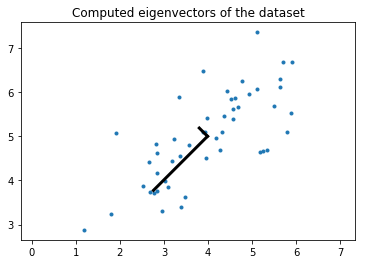

In [38]:
plt.xlim([0.5, 6.5])
plt.ylim([2.0, 8.0])
plt.axis('equal')
plt.plot(X[:,0], X[:,1], lw=0, marker='.')
plt.plot([mu[0],mu[0]+S[0]*U[0,0]], [mu[1],mu[1]+S[0]*U[1,0]], lw=3,
        color='black')
plt.plot([mu[0],mu[0]+S[1]*U[0,1]], [mu[1],mu[1]+S[1]*U[1,1]], lw=3,
        color='black')
plt.title('Computed eigenvectors of the dataset')
plt.show()

In [39]:
def projectData(X, U, K):
    return np.matmul(X, U[:,:K])

def recoverData(Z, U, K):
    return np.matmul(Z,U[:,:K].T)

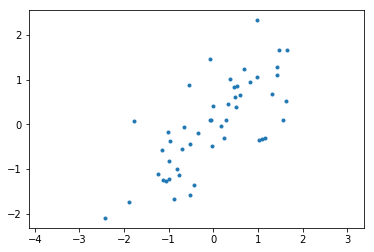

In [40]:
plt.xlim([-4, 3])
plt.ylim([-4, 3])
plt.axis('equal')
plt.plot(X_norm[:,0], X_norm[:,1], lw=0, marker='.')
plt.show()

In [41]:
K = 1
Z = projectData(X_norm, U, K)

In [42]:
# Should be about 1.481274
Z[0]

array([1.49631261])

In [43]:
X_rec = recoverData(Z, U, K)

In [44]:
# Should be about -1.047419, -1.047419
X_rec[0,:]

array([-1.05805279, -1.05805279])

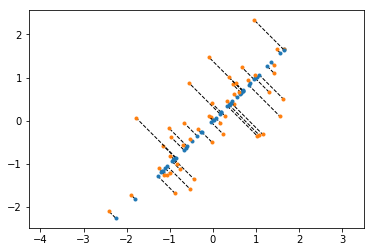

In [45]:
plt.xlim([-4, 3])
plt.ylim([-4, 3])
plt.axis('equal')
for i in range(X_norm.shape[0]):
    plt.plot([X_rec[i,0], X_norm[i,0]], [X_rec[i,1], X_norm[i,1]],
             lw=1, ls='--', color='black')
    plt.plot(X_rec[i,0], X_rec[i,1], lw=0, marker='.', color='C0')
    plt.plot(X_norm[i,0], X_norm[i,1], lw=0, marker='.', color='C1')
plt.show()

### 2.2 PCA in Scikit-learn

In [46]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [47]:
X_norm = StandardScaler().fit_transform(X)
pca = PCA(n_components=1).fit(X_norm)

In [48]:
pca.components_

array([[-0.70710678, -0.70710678]])

In [49]:
pca.get_covariance()

array([[1.02040816, 0.7505412 ],
       [0.7505412 , 1.02040816]])

In [50]:
Z = pca.transform(X_norm)
X_rec = pca.inverse_transform(Z)

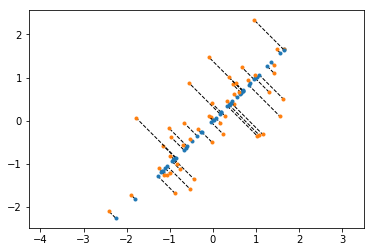

In [51]:
plt.xlim([-4, 3])
plt.ylim([-4, 3])
plt.axis('equal')
for i in range(X_norm.shape[0]):
    plt.plot([X_rec[i,0], X_norm[i,0]], [X_rec[i,1], X_norm[i,1]],
             lw=1, ls='--', color='black')
    plt.plot(X_rec[i,0], X_rec[i,1], lw=0, marker='.', color='C0')
    plt.plot(X_norm[i,0], X_norm[i,1], lw=0, marker='.', color='C1')
plt.show()

### 2.3 PCA on faces

In [52]:
df = sio.loadmat('ex7faces.mat')
X = df['X']

In [53]:
n = np.sqrt(X.shape[1]).astype(int)

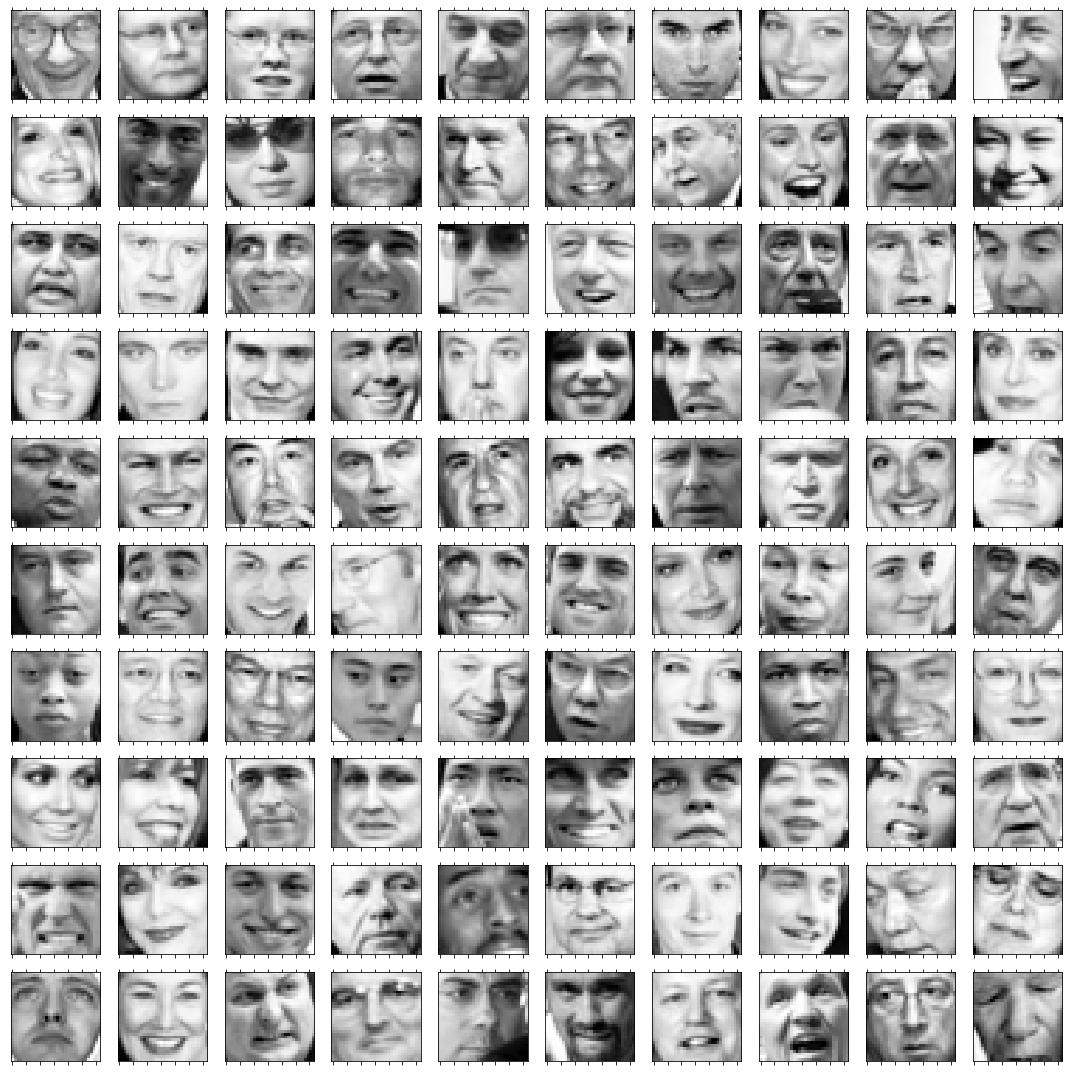

In [54]:
fig, ax = plt.subplots(10, 10, figsize=(15, 15))
for i, a in enumerate(ax.ravel()):
    a.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, 
                  left=False, labelleft=False)
    a.matshow(np.transpose(X[i,:].reshape(n,n)), cmap=plt.cm.Greys_r)
plt.tight_layout()

In [55]:
X_norm, mu, sigma = featureNormalize(X)

In [56]:
U, S = runPca(X_norm)

Top 100 eigenvectors

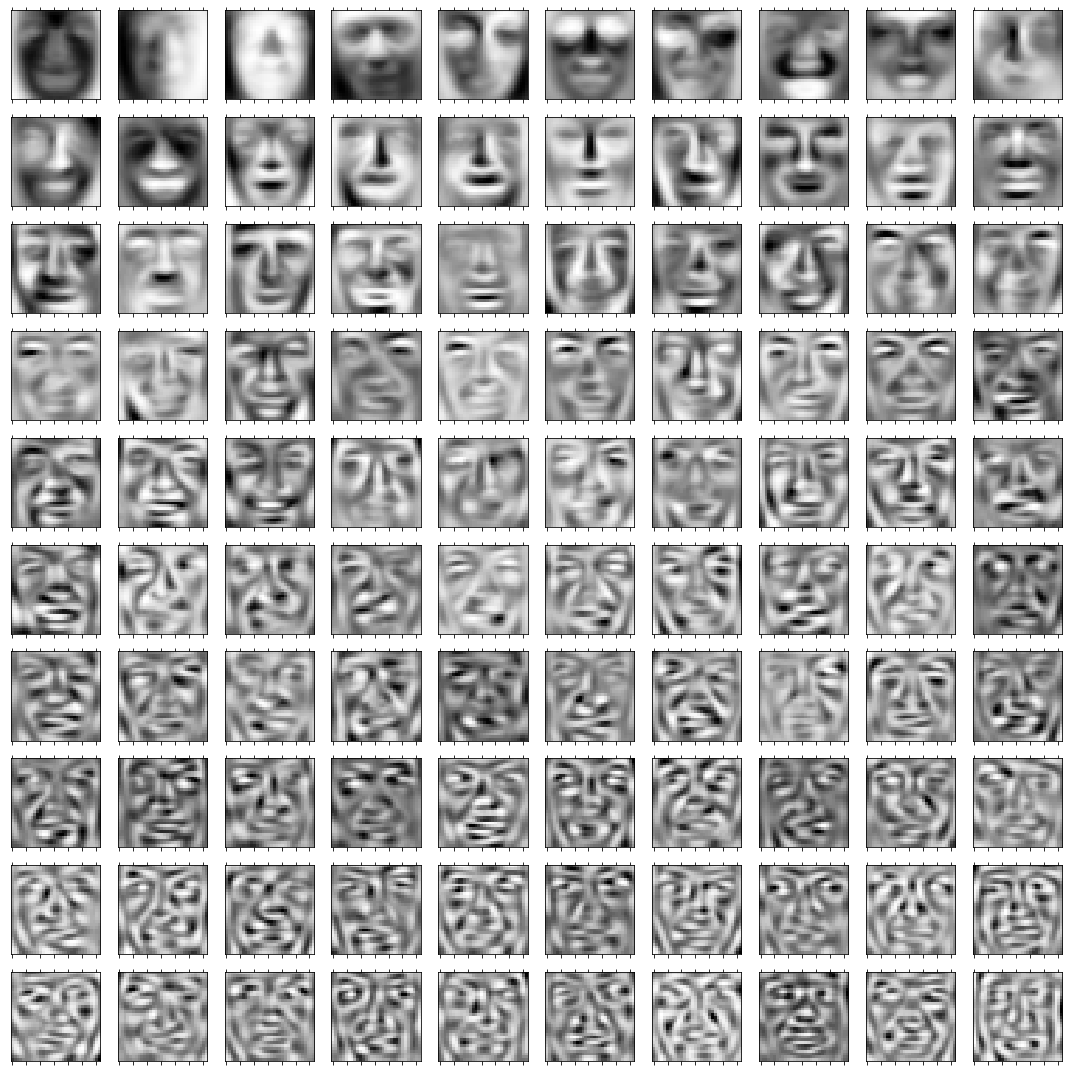

In [57]:
fig, ax = plt.subplots(10, 10, figsize=(15, 15))
for i, a in enumerate(ax.ravel()):
    a.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, 
                  left=False, labelleft=False)
    a.matshow(np.transpose(U[:,i].reshape(n,n)), cmap=plt.cm.Greys_r)
plt.tight_layout()

In [58]:
K = 100
Z = projectData(X_norm, U, K)
X_rec = recoverData(Z, U, K)

Recovered faces using 100 dimensions

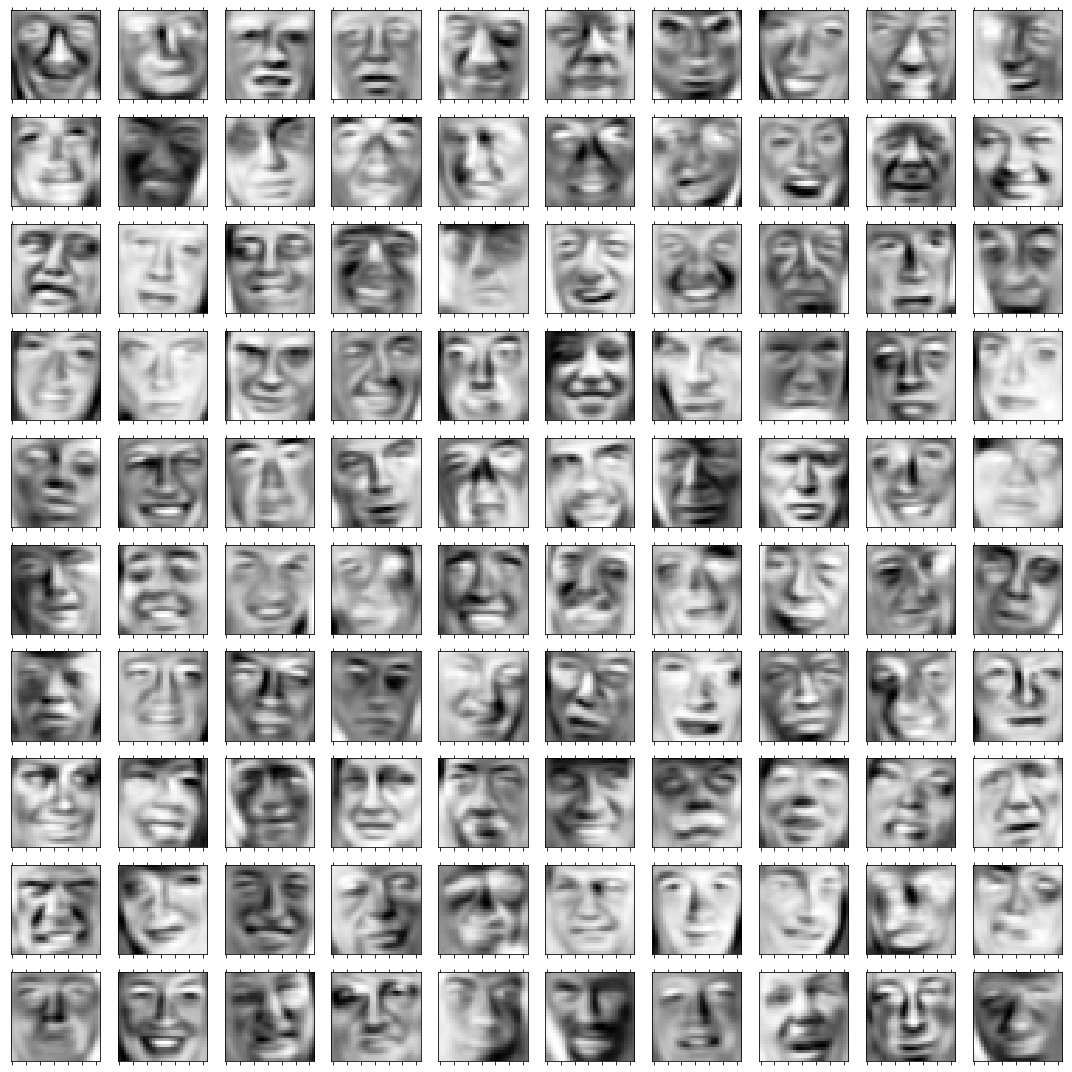

In [59]:
fig, ax = plt.subplots(10, 10, figsize=(15, 15))
for i, a in enumerate(ax.ravel()):
    a.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, 
                  left=False, labelleft=False)
    a.matshow(np.transpose(X_rec[i,:].reshape(n,n)), cmap=plt.cm.Greys_r)
plt.tight_layout()